In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import convmorph as cm
from torch.utils.data import Dataset, DataLoader

## Summary

* I try to build models to learn the mappings from the constituent vectors to the word vectors.
* There are two kinds of mappings: 
  * 2-Char: from single-character word to two-character word
  * 4-char: from two-character word to 4-character NN compounds
* all word vectors are coming from the Tencent embeddings
* Data statistics:
  * 2-char: 120838 => Train 114,796 + Test 6,042
  * 4-char:  75957 => Train  69,915 + Test 6,042
  * Note: Data size has large impact on accuracy. Therefore I control the test data size in 2-Char and 4-Char, so that their test accuracy is comparable. I also sampled 6,042 items from training set to compute a comparable training accuracy.
* Model:
  * Linear projection: Use pseudo-inverse to compute a projection matrix. It projects the 400 dim constituent vectors to 200 word vectors.
  * Deep learning model: a 6-layer convolution-based model. It is not a large model compared to NLP models (e.g. BERT, ~100-200M params), but it already has 11.2M parameters.
  
* Accuracy Table

|         |  DL-Train | DL-Test | Lin-Train | Lin-Test  |
|---------|--------:|------:|-------:|-------:|
| 2-Char  |  .78   | .46  |  .40  |  .39  |
| 4-Char  |  .94   | .74  |  .72  |  .71  |

* Observations:
  * DL does perform marignally better than linear projection in testing data.
  * The training accuracy is much better in DL than in linear projection. But it is still not clear if it is only overfitting or there is something it learned from the training set that is not transferable to testing set.

## Load Data

In [4]:
with open("../data/convmorph_dataset.pkl", "rb") as fin:
    (cm2_vocabs, cm2_embs) = pickle.load(fin)

In [5]:
compound_embedding_path = "../data/tencent_compounds_embeddings.txt.gz"
cm4_vocabs, cm4_embs = cm.load_tencent_compound(compound_embedding_path)

  0%|          | 0/119797 [00:00<?, ?it/s]

In [6]:
len(cm2_vocabs)

129538

In [7]:
cm2_ds = cm.ConvmorphDataset(cm2_vocabs, cm2_embs)
cm4_ds = cm.ConvmorphNNDataset(cm4_vocabs, cm4_embs)
print(f"cm2_dataset: {len(cm2_ds):6d}")
print(f"cm4_dataset: {len(cm4_ds):6d}")

building dataset:   0%|          | 0/129538 [00:00<?, ?it/s]

building dataset:   0%|          | 0/119797 [00:00<?, ?it/s]

cm2_dataset: 120838
cm4_dataset:  75957


### Load train-testing splits

In [8]:
import pickle
cm2_split_path = "../data/split_indices_500k.pkl"
cm4_split_path = "../data/split_indices_char4.pkl"
(cm2_train_ds, cm2_test_ds, 
 cm2_train_eval_ds,
 cm2_train_idxs, cm2_test_idxs) = cm.split_train_test(cm2_split_path, cm2_ds)
(cm4_train_ds, cm4_test_ds, 
 cm4_train_eval_ds,
 cm4_train_idxs, cm4_test_idxs) = cm.split_train_test(cm4_split_path, cm4_ds)

print("cm2: ", len(cm2_train_ds), len(cm2_test_ds), len(cm2_train_eval_ds))
print("cm4: ", len(cm4_train_ds), len(cm4_test_ds), len(cm4_train_eval_ds))

cm2:  114796 6042 6042
cm4:  69915 6042 6042


## Load Model

### DL model

In [9]:
from convmorph import ConvmorphArcModel
# DL model for 2-char-word
model_cm2 = ConvmorphArcModel().to("cuda")
states = torch.load("../data/0403-1959-arc/model.pth")
model_cm2.load_state_dict(states())  # I made a mistake when saving state_dict. The saved state is a bound function.
_ = model_cm2.eval()

# DL model for 4-char-word
model_cm4 = ConvmorphArcModel().to("cuda")
states = torch.load("../data/0413-1204-arc/model.pth")
model_cm4.load_state_dict(states)  # I made a mistake when saving state_dict. The saved state is a bound function.
_ = model_cm4.eval()

In [10]:
print("{:.2f}M parameters".format(sum([x.numel() for x in model_cm2.parameters()])/1e6))

11.06M parameters


### Linear projection model

$$
AX=B \\
X = (A^\top A)^{-1}A^\top B
$$

In [11]:
linprojX_cm2 = cm.make_linear_projection(cm2_ds, cm2_train_idxs)
linproj_cm2 = cm.LinearProjection(linprojX_cm2, "cuda")
linprojX_cm4 = cm.make_linear_projection(cm4_ds, cm4_train_idxs)
linproj_cm4 = cm.LinearProjection(linprojX_cm4, "cuda")

## Metrics

### Two-character words

In [14]:
cm2_eval_embs = torch.tensor(np.vstack([x["target"] for x in cm2_test_ds]), dtype=torch.float32).to("cuda")
cm2_train_eval_embs = torch.tensor(np.vstack([x["target"] for x in cm2_train_eval_ds]), dtype=torch.float32).to("cuda")

In [15]:
cm2_acc_test_dl = cm.compute_accuracy(model_cm2, DataLoader(cm2_test_ds, batch_size=128, shuffle=False), 
                                      cm2_eval_embs, topk=1)
cm2_acc_train_dl = cm.compute_accuracy(model_cm2, DataLoader(cm2_train_eval_ds, batch_size=128, shuffle=False), 
                                       cm2_train_eval_embs, topk=1)
print("CM2 DL: ")
print("Train/Test Acc: {:.4f}/{:.4f}".format(cm2_acc_train_dl, cm2_acc_test_dl))

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

CM2 DL: 
Train/Test Acc: 0.7761/0.4556


In [16]:
cm2_acc_test_lin = cm.compute_accuracy(linproj_cm2, DataLoader(cm2_test_ds, batch_size=128, shuffle=False), 
                                      cm2_eval_embs, topk=1)
cm2_acc_train_lin = cm.compute_accuracy(linproj_cm2, DataLoader(cm2_train_eval_ds, batch_size=128, shuffle=False), 
                                       cm2_train_eval_embs, topk=1)
print("CM2 Linear: ")
print("Train/Test Acc: {:.4f}/{:.4f}".format(cm2_acc_train_lin, cm2_acc_test_lin))

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

CM2 Linear: 
Train/Test Acc: 0.4005/0.3883


### Four-character Words

In [17]:
cm4_eval_embs = torch.tensor(np.vstack([x["target"] for x in cm4_test_ds]), dtype=torch.float32).to("cuda")
cm4_train_eval_embs = torch.tensor(np.vstack([x["target"] for x in cm4_train_eval_ds]), dtype=torch.float32).to("cuda")

In [18]:
cm4_acc_test_dl = cm.compute_accuracy(model_cm4, DataLoader(cm4_test_ds, batch_size=128, shuffle=False), 
                                      cm4_eval_embs, topk=1)
cm4_acc_train_dl = cm.compute_accuracy(model_cm4, DataLoader(cm4_train_eval_ds, batch_size=128, shuffle=False), 
                                       cm4_train_eval_embs, topk=1)
print("CM4 DL: ")
print("Train/Test Acc: {:.4f}/{:.4f}".format(cm4_acc_train_dl, cm4_acc_test_dl))

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

CM4 DL: 
Train/Test Acc: 0.9396/0.7380


In [19]:
cm4_acc_test_lin = cm.compute_accuracy(linproj_cm4, DataLoader(cm4_test_ds, batch_size=128, shuffle=False), 
                                      cm4_eval_embs, topk=1)
cm4_acc_train_lin = cm.compute_accuracy(linproj_cm4, DataLoader(cm4_train_eval_ds, batch_size=128, shuffle=False), 
                                       cm4_train_eval_embs, topk=1)
print("CM4 Linear: ")
print("Train/Test Acc: {:.4f}/{:.4f}".format(cm4_acc_train_lin, cm4_acc_test_lin))

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

CM4 Linear: 
Train/Test Acc: 0.7210/0.7061


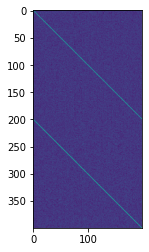

In [27]:
plt.imshow(linprojX_cm2)

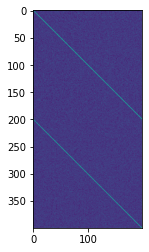

In [26]:
plt.imshow(linprojX_cm4)